## NEP Loss

We have run 300000 steps!


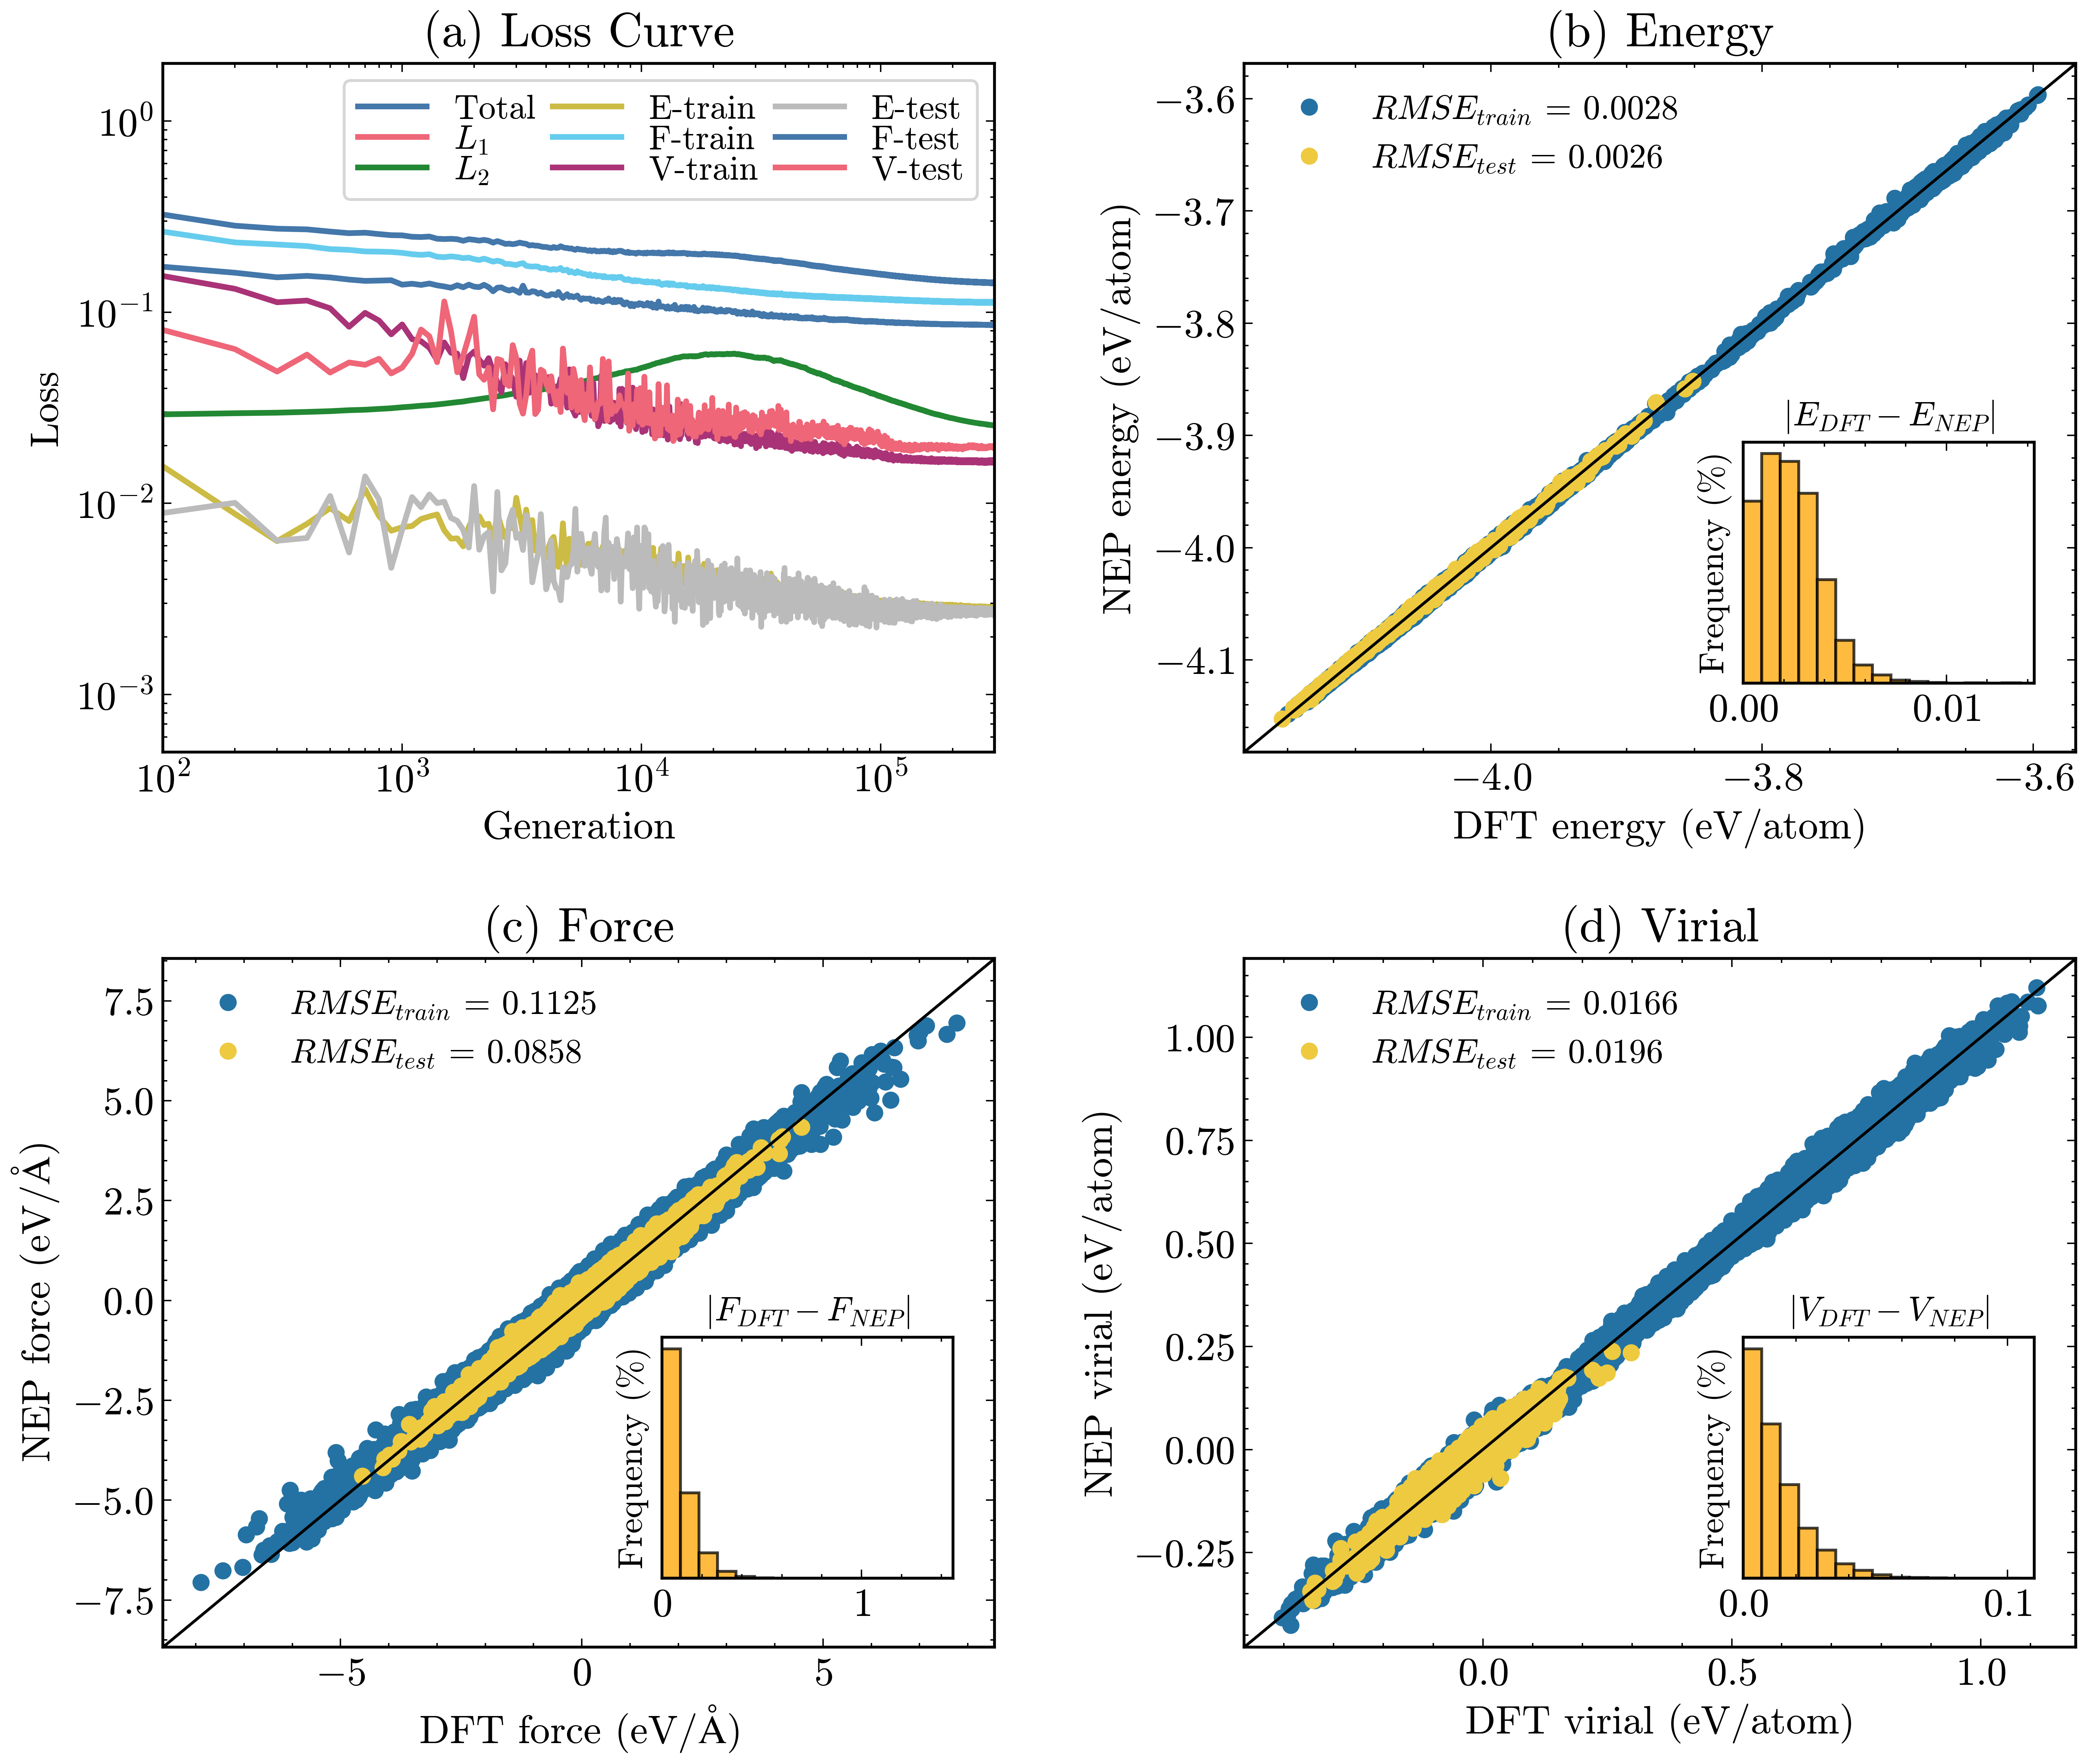

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])
plt.rcParams.update({
    'font.size': 14,
    'axes.linewidth': 1,
    'axes.unicode_minus': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in'
})

def load_data(loss_file='loss.out', energy_train_file='energy_train.out', 
              force_train_file='force_train.out', virial_train_file='virial_train.out',
              energy_test_file='energy_test.out', force_test_file='force_test.out', 
              virial_test_file='virial_test.out'):
    try:
        loss = np.loadtxt(loss_file)
        loss[:, 0] = np.arange(1, len(loss) + 1) * 100
        print(f"We have run {loss[-1, 0]:.0f} steps!")
    except Exception as e:
        raise FileNotFoundError(f"Error loading {loss_file}: {e}")

    def load_optional_file(file_path):
        if os.path.exists(file_path):
            return np.loadtxt(file_path)
        else:
            print(f"Warning: {file_path} not found.")
            return None

    energy_train = np.loadtxt(energy_train_file)
    force_train = np.loadtxt(force_train_file)
    virial_train = np.loadtxt(virial_train_file)
    
    energy_test = load_optional_file(energy_test_file)
    force_test = load_optional_file(force_test_file)
    virial_test = load_optional_file(virial_test_file)
    
    return loss, energy_train, force_train, virial_train, energy_test, force_test, virial_test

def plot_rmse_error(ax, true_values, predicted_values, color, label):
    errors = predicted_values - true_values
    rmse = np.sqrt(np.mean(errors**2))
    ax.plot(true_values, predicted_values, 'o', color=color, ms=5, label=f'{label} = {rmse:.4f}')

def plot_hist(ax, true_values, predicted_values, title, bins=15, alpha=0.75):
    errors = predicted_values - true_values
    abs_errors = np.abs(errors)
    
    inset_ax = ax.inset_axes([0.6, 0.1, 0.35, 0.35])
    inset_ax.hist(abs_errors, bins=bins, color='orange', alpha=alpha, density=True, edgecolor='black')
    inset_ax.set_title(title, fontsize=12)
    inset_ax.set_ylabel("Frequency (%)", fontsize=12)
    inset_ax.set_xlim([0, None])
    inset_ax.set_ylim([0, None])
    # inset_ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    inset_ax.set_yticks([])
    inset_ax.yaxis.set_label_position("left")
    inset_ax.yaxis.tick_left()

def plot_training_results():
    loss, energy_train, force_train, virial_train, energy_test, force_test, virial_test = load_data()

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    col_list = ["Total", r"$L_{1}$", r"$L_{2}$", "E-train", "F-train", "V-train", "E-test", "F-test", "V-test"]
    if energy_test is None:
        for i, label in zip(range(1, 7), col_list[:6]):
            plt.loglog(loss[:, 0], loss[:, i], ls="-", lw=2, label=label)
    else:
        for i, label in zip(range(1, 10), col_list):
            plt.loglog(loss[:, 0], loss[:, i], ls="-", lw=2, label=label)
    plt.xlim(1e2, loss[:, 0].max())
    plt.ylim(5e-4, 2e0)
    plt.xlabel('Generation')
    plt.ylabel('Loss')
    plt.legend(loc="upper right", ncol=3, frameon=True, fontsize=12, labelspacing=0, columnspacing=0.5)
    plt.title("(a) Loss Curve")
    
    plt.subplot(2, 2, 2)
    ax = plt.gca()
    plot_rmse_error(ax, energy_train[:, 1], energy_train[:, 0], "#2472A3", r"$RMSE_{train}$") 
    if energy_test is not None:
        plot_rmse_error(ax, energy_test[:, 1], energy_test[:, 0], "#EECA40", r"$RMSE_{test}$")
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [xmin, xmax], c="black", lw=1)
    ax.set_xlabel('DFT energy (eV/atom)')
    ax.set_ylabel('NEP energy (eV/atom)')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])
    ax.set_title("(b) Energy")
    ax.legend(loc="upper left", fontsize=12)
    plot_hist(ax, energy_train[:, 1], energy_train[:, 0], r"$|E_{DFT}-E_{NEP}|$")
    
    plt.subplot(2, 2, 3)
    ax = plt.gca()
    plot_rmse_error(ax, force_train[:, 3:].flatten(), force_train[:, :3].flatten(), "#2472A3", r"$RMSE_{train}$") 
    if force_test is not None:
        plot_rmse_error(ax, force_test[:, 3:].flatten(), force_test[:, :3].flatten(), "#EECA40", r"$RMSE_{test}$")
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [xmin, xmax], c="black", lw=1)
    ax.set_xlabel(r'DFT force (eV/$\rm{\AA}$)')
    ax.set_ylabel(r'NEP force (eV/$\rm{\AA}$)')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])
    ax.set_title("(c) Force")
    ax.legend(loc="upper left", fontsize=12)
    plot_hist(ax, force_train[:, 3:].flatten(), force_train[:, :3].flatten(), r"$|F_{DFT}-F_{NEP}|$")

    plt.subplot(2, 2, 4)
    ax = plt.gca()
    plot_rmse_error(ax, virial_train[:, 6:].flatten(), virial_train[:, :6].flatten(), "#2472A3", r"$RMSE_{train}$") 
    if virial_test is not None:
        plot_rmse_error(ax, virial_test[:, 6:].flatten(), virial_test[:, :6].flatten(), "#EECA40", r"$RMSE_{test}$")
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [xmin, xmax], c="black", lw=1)
    ax.set_xlabel('DFT virial (eV/atom)')
    ax.set_ylabel('NEP virial (eV/atom)')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])
    ax.set_title("(d) Virial")
    ax.legend(loc="upper left", fontsize=12)
    plot_hist(ax, virial_train[:, 6:].flatten(), virial_train[:, :6].flatten(), r"$|V_{DFT}-V_{NEP}|$")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.savefig("nep_loss_and_rmse.png", bbox_inches='tight')

def main():
    plot_training_results()

if __name__ == '__main__':
    main()